In [1]:
import pysam
import random

bases_choices = ['A','T','C','G']

In [2]:
header = { 'HD': {'VN': '1.0'},
            'SQ': [{'LN': 1575, 'SN': 'chr1'},
                   {'LN': 1584, 'SN': 'chr2'}] }

with pysam.AlignmentFile('ex1.bam', "wb", header=header) as outf:
    a = pysam.AlignedSegment()
    a.query_name = "example_read"
    a.query_sequence= ''.join(random.choice(bases_choices) for i in range(35))
    a.flag = 99
    a.reference_id = 0
    a.reference_start = 32
    a.mapping_quality = 20
    a.cigar = ((0,10), (2,1), (0,25))
    a.next_reference_id = 0
    a.next_reference_start=199
    a.query_qualities = pysam.qualitystring_to_array("<<<<<<<<<<<<<<<<<<<<<:<9/,&,22;;<<<")
    a.template_length=167
    a.tags = (("NM", 1),
              ("RG", "L1"))
    outf.write(a)

In [3]:
bam_file = pysam.AlignmentFile('ex1.bam' , 'rb' , check_sq=False)
iter_ = bam_file.fetch('chr1')
for i in iter_:
    read_1 = str(i)
    
read_list = read_1.split('\t')
sequnce = read_list[9]
print(sequnce)

ACTTGTCGTTATTTTGGCTCTCTTGACCTATCCAT


## Sequence Extraction
Since most BAM/SAM/CRAM files have a universal format of attributes, the seqence we want to analyse is mostly found in the specified attribute, althought the test was dobe using a BAM file due to some technical issues with the cram file which has left us unable to determine precisely the use of CRAM file

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
import time

In [113]:
idx_list = range(1000)
sequences = list()
for idx in idx_list:
    sequences.append(''.join(random.choice(['A','T','C','G']) for i in range(10000)))
print(sequences[0])

CGGAGCGCCGCGAGAGCTCCACATGGCGGCGTATAGCCGGACCCGGGCATGATCTATGGCCATAGAAAGTCATCGATGAACTATGTTTGAGCAGAATATTACTAGAACCTCACAGTACCGTGCCGCTTAGCACACTGGCGAGGACTGAAAACGACCTGCCTCTTCATGATTCGCCATTCGCATAGGTGCAGTAAACTGACCTGGCGGTCCACACACTCTCGGAGCGGACCAACCGGTGTGGGGGTCTATGGTGTCACATAAAGCGGTATTTCTTGGTTGCAGGGGCGGGAGTTCGGAAATGTCGATTTTCACTACTCGCTATAGGAATATTTGGCAATCCCAAAGATGTTGATCGATCCTCCAGTACTGACATGGGACCTATCCCGCCACGCCCAGGAAGCTGGGACGCTTTAGTTGCCATTGCCAGTCTCACGGCGCCAGAGCGAGTCGGACCATGCATCGAGTGAGTGGCGGTAGCTGACAGCATGCTGGTTTACAGTCCCAACATTCCAAAAAAAGTGTTATTGATATCCTTGACACTTGTCAAAACAAGACGGCACCTGCACGCTGAAGTTTACTAGGCTGAAGCCTACCGCTAGCTTCCTGCACGGGTGCCTGGCTAGTTCTGGCGGGATGAAAGAGGCCACTCAAGCGGAGCAGGGATTAGTTCCCTTGCGAAATGTCTATTCTCTTGCATGGCACGTGAGGCCGAACGATCTAAAAAGCCGCGCCAGCTATACAAACGGAGCCCAATGTGCCTCGACAGCCTTGATACCGCCATGCTAGACCGCCCATCATCGAGCAAGATCACCATGTCTTTCCTAAGGGGTACCCGGTAAAATTGCGGGACTGTTTTACGAGCCGTCGTCGCCGATTCCATCAACCGGTCTACGCGTCGTCTGCGATGAGTCCGTGTGCTTTCGTCTCAGATTACAGGTACCATATTTCGATATTATAGTTGGAGCGGCTCTCTTTGTCTACTTATATAAGTTGTTGCTCC

In [123]:
data = pd.DataFrame(data = sequences, index = idx_list, columns=["Sequence"])
data.head()

,Sequence
0,CGGAGCGCCGCGAGAGCTCCACATGGCGGCGTATAGCCGGACCCGG...
1,TAAATCCCAGCGGTTGGCCCAGATCGCTGATTGCCGATGCCGATAA...
2,TAAAAAGGCGAACCAGGCTCTTGGGACGGAAGTACCCTGAAAAGAG...
3,AGCTTAAGGGATGAACCAGGGGATGAACTGGGTTCCGATTGCATCC...
4,CAGGGAAAATTTCGTTATATACCCAGGCTGCAATGAAGCTTGCCCG...


To test the performance of the tools we're using, we have randomly generated 100 indexed sequences 10000 base long, then we stored them in a pandas DataFrame in order to use the methods available in `Pandas`. we'll start by extracting one part of the sequence.

In [115]:
ext_sequences = data.Sequence.str[100:301]
idxs = pd.Series(idx_list)
df = pd.DataFrame(data=ext_sequences, index=idxs)

In [117]:
new_df = df["Sequence"].apply(lambda x: pd.Series(list(x)))
new_df.columns = ['base-%d'%i for i in range(100,301)]
new_df.memory_usage(deep=True).sum() / 1024**2

12.659072875976562

After extracting the arbitrary bases we need to analyse, we measure the total meamory usage of 1000 rows with 200 bases to be `12.66 MB` which would be reduced if the Data type was to be converted to Categorical rather than being in string type.

Since there are only 4 unique data value, turning the data types to `Category` is bound to reduce the memory foot print, making it easier for less powerful machines to read the data.

In [122]:
cat_cols = new_df.columns
new_df = new_df[cat_cols].astype('category')
# measure the memory usage of the new DataFrame and compare

new_mem = new_df.memory_usage(deep=True).sum() / 1024**2
print("The new memory usage is : ", new_mem)

The new memory usage is :  0.2805938720703125


Thanks to categorical data types we have been able to reduce the memory usage from 12.66 Mb to 0.28 Mb, the same can be applied for larger datasets.

In [156]:
def measure_time(func):
    start = time.time()
    func()
    return time.time() - start

In [157]:
import numpy as np

In [181]:
rows_list = range(0,10000,1000)
start = time.time()
idx_list = range(15000)
sequences = list()
for idx in idx_list:
    sequences.append(''.join(random.choice(['A','T','C','G']) for i in range(1000)))
print(time.time() - start)

29.068942070007324


In [196]:
def df_creator(rows , initial , size):
    # turning the sequences to DataFrames
    data = pd.DataFrame(data=sequences[:rows+1] , index=idx_list[:rows+1] , columns=['Sequence'])
    # extracting arbitrary bases
    data["Sequence"] = data["Sequence"].str[initial:initial+size+1]
    # splitting over every base
    df = data["Sequence"].apply(lambda x: pd.Series(list(x))).astype('category')
    data = pd.concat([data, df], axis=1)
    data.drop(["Sequence"],axis=1,inplace=True)
    return data

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,C,G,T,A,A,G,G,G,G,G,...,A,T,T,G,G,A,G,G,C,A
1,C,A,T,C,A,G,A,G,T,C,...,T,T,T,C,A,G,G,T,C,A
2,A,T,C,C,C,T,T,C,C,G,...,A,C,T,C,G,C,C,T,G,A
3,T,G,G,C,A,G,G,A,A,T,...,G,A,T,A,T,C,T,G,G,G
4,C,C,G,A,C,A,T,G,G,G,...,T,G,T,A,A,G,G,C,G,C
5,G,C,T,A,T,G,C,G,A,T,...,C,G,C,A,T,G,G,C,A,C
6,C,C,T,A,T,G,G,C,C,G,...,C,C,C,G,A,C,T,G,T,G
7,C,T,C,A,C,G,T,C,C,G,...,A,G,G,G,C,G,T,A,A,G
8,A,C,A,G,G,C,C,T,C,A,...,G,C,T,G,G,A,C,C,T,G
9,G,G,C,G,C,C,A,T,G,A,...,A,T,A,C,G,T,C,T,C,C


In [197]:
thousand_mem = df_creator(1000,100,300).memory_usage(deep=True).sum()/1024**2

In [198]:
fivthou_mem = df_creator(5000,100,300).memory_usage(deep=True).sum()/1024**2

In [199]:
tenthou_mem = df_creator(10000,100,300).memory_usage(deep=True).sum()/1024**2

In [200]:
fifthou_mem = df_creator(15000,100,300).memory_usage(deep=True).sum()/1024**2

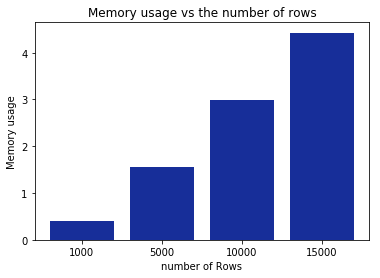

<Figure size 432x288 with 0 Axes>

In [236]:
positions = np.arange(4)
plt.bar(positions, height=[thousand_mem,fivthou_mem, tenthou_mem , fifthou_mem], color ='#172e99')
plt.xticks(positions,[1000, 5000 , 10000 , 15000])
plt.xlabel("number of Rows")
plt.ylabel("Memory usage")
plt.title("Memory usage vs the number of rows")
plt.show()
plt.savefig('memory_usage.jpeg')

In [220]:
def df_creator(bases):
    # turning the sequences to DataFrames
    data = pd.DataFrame(data=sequences , index=idx_list , columns=['Sequence'])
    # extracting arbitrary bases
    data["Sequence"] = data["Sequence"].str[0:bases+1]
    # splitting over every base
    df = data["Sequence"].apply(lambda x: pd.Series(list(x))).astype('category')
    data = pd.concat([data, df], axis=1)
    data.drop(["Sequence"],axis=1,inplace=True)
    return data

In [229]:
base_200 = df_creator(200).memory_usage(deep=True).sum()/1024**2
print(base_200)

2.9566802978515625


In [243]:
base_400 = df_creator(400).memory_usage(deep=True).sum()/1024**2

In [241]:
base_600 = df_creator(600).memory_usage(deep=True).sum()/1024**2

In [224]:
base_800 = df_creator(800).memory_usage(deep=True).sum()/1024**2

In [244]:
mem_usage = [base_200,base_400,base_600,base_800]
print(mem_usage)

[2.9566802978515625, 5.8985748291015625, 8.840469360351562, 11.782363891601562]


Text(0.5,1,'Memory Usage vs Number of Bases')

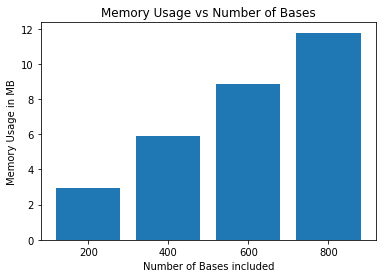

In [252]:
x = [200,400,600,800]
plt.bar(positions, height=mem_usage)
plt.xticks(positions,[200,400,600,800])
plt.xlabel("Number of Bases included")
plt.ylabel("Memory Usage in MB")
plt.title("Memory Usage vs Number of Bases")